# Supervised Fraud Detection

Supervised machine learning model to predict fraudulent payments using the `fraud_cases_master.csv` dataset. The objective is to leverage labeled data to identify patterns indicative of fraud and to assess the model's ability to accurately classify fraudulent transactions.


In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## 1. Data Loading and Preparation

We load the `fraud_cases_master.csv` dataset, which includes a `Fraud flag` column indicating fraudulent transactions. Date columns are converted to datetime objects, and `time_to_payment` is calculated as a potential feature. Missing values in numerical columns are filled with the median, and categorical columns with the mode. The `Fraud flag` is our target variable (y).


In [17]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')
print(f"Data directory is set to: {data_dir}")

payment_master_path = os.path.join(data_dir, 'payments_master.csv')
fraud_case_master_path = os.path.join(data_dir, 'fraud_cases_master.csv')
research_team_master_path = os.path.join(data_dir, 'research_team_master.csv')
research_team_member_master_path = os.path.join(data_dir, 'research_team_member_master.csv')
print("************************\n")
print(f"Payment master path: {payment_master_path}")
print(f"Fraud case master path: {fraud_case_master_path}")
print(f"Research team master path: {research_team_master_path}")
print(f"Research team member master path: {research_team_member_master_path}")

Data directory is set to: c:\Users\homep\Documents\Projects\bupa_case_study\data
************************

Payment master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\payments_master.csv
Fraud case master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\fraud_cases_master.csv
Research team master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_master.csv
Research team member master path: c:\Users\homep\Documents\Projects\bupa_case_study\data\research_team_member_master.csv


In [18]:
# Load the dataset
df_fraud = pd.DataFrame()

try:
    df_fraud = pd.read_csv(fraud_case_master_path)
except FileNotFoundError:
    print("Error: fraud_cases_master.csv not found. Please ensure the file is in the correct directory.")
    exit()

# Convert date columns to datetime objects if needed (for potential feature engineering later)
date_cols = ['Date received', 'Date of invoice', 'Date of authorisation', 'Payment due date', 'Date of payment']
for col in date_cols:
    if col in df_fraud.columns:
        df_fraud[col] = pd.to_datetime(df_fraud[col], errors='coerce')

# Calculate 'time to payment' as a potential feature
df_fraud['time_to_payment'] = (df_fraud['Date of payment'] - df_fraud['Date received']).dt.days

# Drop original date columns as we have 'time_to_payment'
df_fraud = df_fraud.drop(columns=date_cols, errors='ignore')

# Handle potential missing values (e.g., for 'time_to_payment') before splitting
df_fraud.dropna(subset=['time_to_payment'], inplace=True)

X = df_fraud.drop('Fraud flag', axis=1)
y = df_fraud['Fraud flag']

print(f"Dataset loaded with {len(df_fraud)} records after preprocessing.")
print(df_fraud.head())


Dataset loaded with 700 records after preprocessing.
  Research team    Submitted by Invoice number  \
0    Immunology  Lauren Houston      INV-02278   
1     Neurology   Carlos Martin      INV-78486   
2      Genetics    Leah Johnson      INV-44139   
3      Genetics  Isaac Gonzalez      INV-11466   
4    Immunology  Lauren Houston      INV-81540   

                                Description of spend  Invoice value  \
0  "Procured immunohistochemistry staining kits f...       19366.92   
1  "Subscription to specialized neuroscience data...        6839.49   
2  "Procured microcentrifuge tubes, pipette tips,...       13233.00   
3  "Purchased CRISPR-Cas9 components for targeted...        7390.16   
4  "Payment for conference registration and poste...       11050.13   

   Authorised by  Payment amount Payment authoriser Payment Status  \
0  Sarah Collins        19366.92     Antonio Wilson           Paid   
1   Dennis White         6839.49     Antonio Wilson           Paid   
2    Devi

## 2. Feature Engineering and Preprocessing

We define numerical and categorical features for our model. Similar to the regression analysis, numerical features are scaled using `StandardScaler` and categorical features are one-hot encoded using `OneHotEncoder`. The data is then split into training and testing sets, with stratification to ensure a balanced representation of fraudulent and non-fraudulent cases in both sets.


In [19]:
# Identify categorical and numerical features for preprocessing
categorical_features = ['Research team', 'Type of expense', 'Company', 'Payment Status', 'Submitted by', 'Authorised by', 'Payment authoriser']
numerical_features = ['Invoice value', 'Payment amount', 'time_to_payment']

# Ensure all features exist in X, filter if not
categorical_features = [f for f in categorical_features if f in X.columns]
numerical_features = [f for f in numerical_features if f in X.columns]

X = X[categorical_features + numerical_features]

# Preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify for imbalanced classes

print("Data split into training and testing sets with stratification.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Data split into training and testing sets with stratification.
X_train shape: (560, 10), y_train shape: (560,)
X_test shape: (140, 10), y_test shape: (140,)


## 3. Model Training and Evaluation

We build a `Pipeline` that combines the preprocessing steps with a `RandomForestClassifier`. The model is trained on the preprocessed training data, and then predictions are made on the test set. We evaluate the model using:
*   **Accuracy**
*   **Confusion Matrix:** To understand true positives, true negatives, false positives, and false negatives.
*   **Classification Report:** Providing Precision, Recall, and F1-score for each class.
*   **ROC-AUC Score:** To assess the model's ability to distinguish between classes.


In [20]:
# Define the model pipeline
model_fraud = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', RandomForestClassifier(random_state=42))])

# Train the model
model_fraud.fit(X_train, y_train)

# Make predictions
y_pred = model_fraud.predict(X_test)
y_pred_proba = model_fraud.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

# Evaluate the model
print("\n--- Supervised Model Evaluation for Fraud Detection ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")



--- Supervised Model Evaluation for Fraud Detection ---
Accuracy: 0.96

Confusion Matrix:
[[134   0]
 [  5   1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       134
           1       1.00      0.17      0.29         6

    accuracy                           0.96       140
   macro avg       0.98      0.58      0.63       140
weighted avg       0.97      0.96      0.95       140

ROC-AUC Score: 0.78


## 4. Visualization

C:\Users\homep\AppData\Local\Temp\ipykernel_2132\2734565055.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


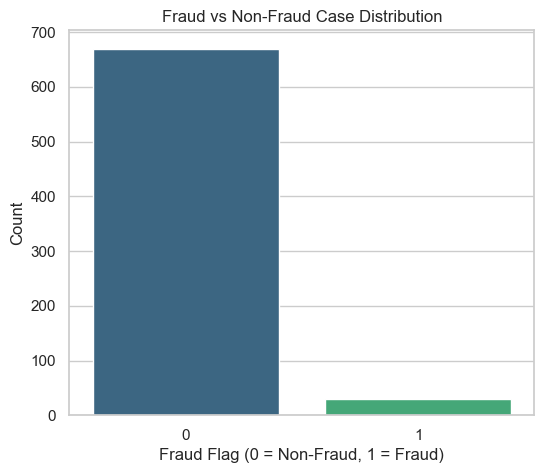

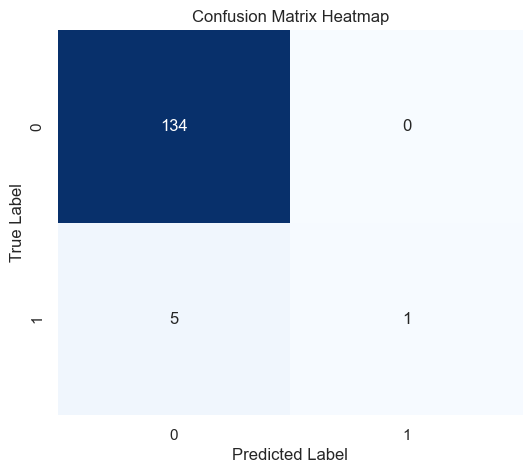

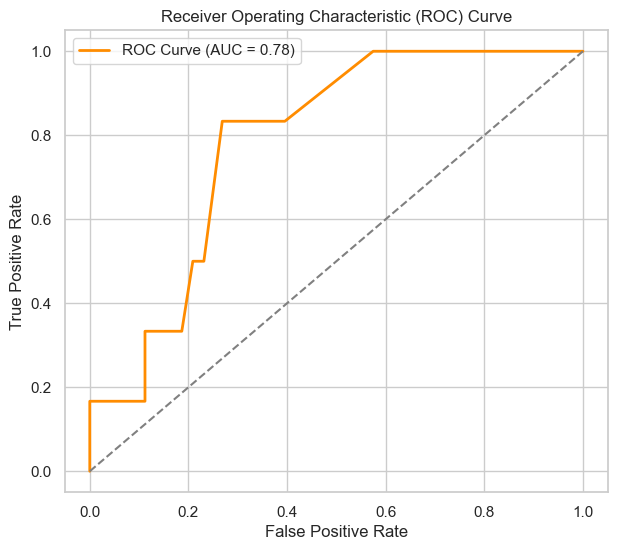

C:\Users\homep\AppData\Local\Temp\ipykernel_2132\2734565055.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='mako')


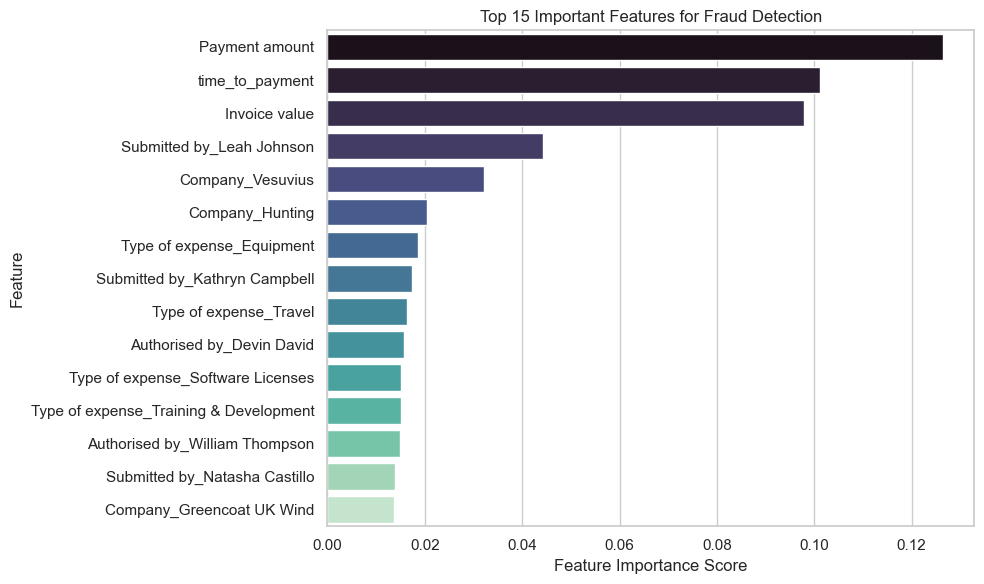

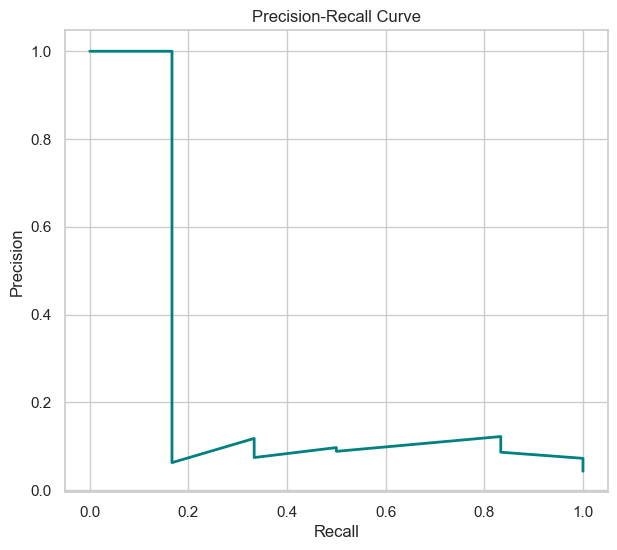

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Class distribution
plt.figure(figsize=(6,5))
sns.countplot(x=y, palette='viridis')
plt.title('Fraud vs Non-Fraud Case Distribution')
plt.xlabel('Fraud Flag (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance Plot
rf_model = model_fraud.named_steps['classifier']
feature_names = (numerical_features + 
                 list(model_fraud.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_features)))

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='mako')
plt.title('Top 15 Important Features for Fraud Detection')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Precision vs Recall visualization (for imbalanced data)
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='teal', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()